In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import tqdm
import numpy
import pandas
import SDA.analytics
import SDA.clustquality

In [ ]:
plt.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(2, 3, figsize = (20, 11))
ax_fmi, ax_silh_all, ax_silh_best, _, ax_explained_variance, ax_silh_reduced = axes.flat

methods = [
    ('pca', 1, { 'svd_solver': "full", 'random_state': 42 }),
    ('umap', 2, { 'random_state': 42 }),
    ('ae', 3, { 'n_features': 100 }),
    ('rtd_ae', 4, { })
]
TRY_NUM_FEATURES = list(range(10, 201, 10))

for subj in [ 1, 2, 3 ]:
    match subj:
        case 1:
            N_STAGES = 9
        case 2:
            N_STAGES = 8
        case 3:
            N_STAGES = 10
    print(N_STAGES)

    for (name, _, __) in methods:
        silh_reduced = [ ]
        explained_variance = [ ]

        for n_components in tqdm.tqdm(TRY_NUM_FEATURES, desc = name):
            folder = f"Subj{subj}/exp_full_flow/features_reduced/{name}/{n_components}"

            reduced_features = numpy.load(f"{folder}/features.npy")

            explained_variance.append(float(numpy.loadtxt(f"{folder}/explained_variance.txt")))

            results = pandas.read_csv(f"{folder}/results.csv")
            try:
                result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
                edges = numpy.fromstring(result['St_edges'].strip('[]'), sep = ' ', dtype = numpy.uint)
            except:
                edges = None
        
            if edges is not None:
                silh_reduced.append(SDA.clustquality.calc_stage_metr_noground(reduced_features, edges, [ "Silh" ]).mean()["Silh"])
            else:
                if len(silh_reduced) > 0: silh_reduced.append(silh_reduced[-1])

        while len(silh_reduced) < len(TRY_NUM_FEATURES): silh_reduced.insert(0, silh_reduced[0])

        axes[0][subj - 1].set_ylim(0, 1)
        axes[0][subj - 1].plot(TRY_NUM_FEATURES, explained_variance, label = name)
        
        axes[1][subj - 1].set_ylim(0, 0.45)
        axes[1][subj - 1].plot(TRY_NUM_FEATURES, silh_reduced, label = name)

axes[0][0].yaxis.set_label_text("Explained variance")
axes[1][0].yaxis.set_label_text("Silhouette coefficient")

axes[0][0].set_title("Subject – 1")
axes[0][1].set_title("Subject – 2")
axes[0][2].set_title("Subject – 3")

for ax in axes.flat:
    ax.xaxis.set_label_text('Number of components')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.49, 0.28))

fig.savefig(f"article/dimreduct.svg")

In [4]:
import mne

In [23]:
def draw(subj, folder, ax1):
    match subj:
        case 'Subj1':
            N_STAGES = 9
        case 'Subj2':
            N_STAGES = 8
        case 'Subj3':
            N_STAGES = 10
    print(N_STAGES)
        
    folder = f"{subj}/exp_full_flow/results/{folder}"

    raw_data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif").drop_channels(ch_names = [ "A1", "A2" ])

    epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ "A1", "A2" ])
    if subj == "Subj2": # m8 (artifacts at the end)
        epochs = epochs[:-2]

    results = pandas.read_csv(f"{folder}/results.csv")
    st_edges_list = [ ]
    for st_edges in results["St_edges"]:
        st_edges = numpy.fromstring(st_edges.strip('[]'), sep = ' ', dtype = numpy.uint)
        st_edges_list.append(st_edges)
    results["St_edges"] = st_edges_list

    df_st_edges = pandas.read_csv(f"{folder}/df_st_edges.csv")
    st_edges_list = [ ]
    for st_edges in df_st_edges["St_edges"]:
        st_edges = numpy.fromstring(st_edges.strip('[]'), sep = ' ', dtype = numpy.uint)
        st_edges_list.append(st_edges)
    df_st_edges["St_edges"] = st_edges_list

    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_edges = numpy.array(best_result['St_edges'])

    pca_features = numpy.load(f"{folder}/pca_features.npy")

    SDA.analytics.plot_eeg_stages(raw_data, best_edges, epochs, pca_features, df_st_edges, best_result, ax = ax1, resolution = 1)

8
Opening raw data file Subj2/src/data_rr_filt-raw.fif...
    Range : 4000 ... 1176000 =      8.000 ...  2352.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj2\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2019 matching events found
No baseline correction applied
0 projection items activated
8
Opening raw data file Subj2/src/data_rr_filt-raw.fif...
    Range : 4000 ... 1176000 =      8.000 ...  2352.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj2\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2019 matching events found
No baseline correction applied
0 projection items activated
8
Opening raw data file Subj2/src/data_rr_filt-raw.fif...
    Range : 4000 ... 1176000 =      8.000 ...  2352.000 secs
Ready.
Reading d:\HSE

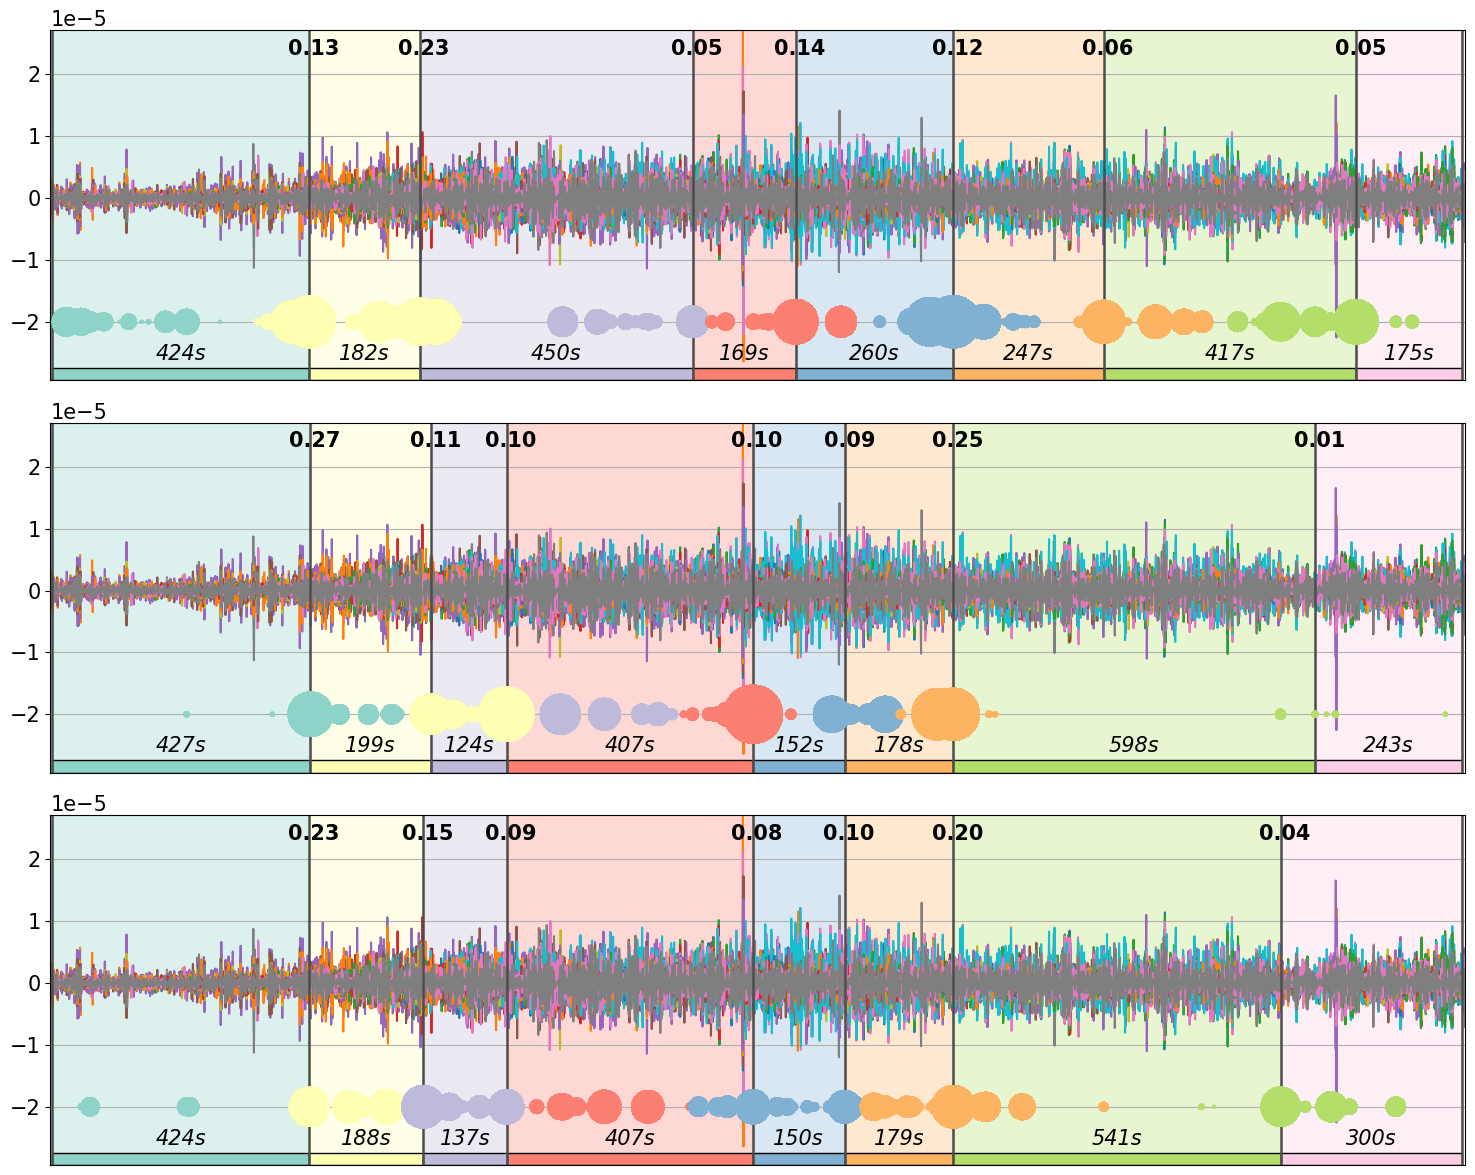

In [24]:
subj = "Subj2"
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(3, 1, figsize = (15, 12))

draw(subj, "traditional", ax[0])
draw(subj, "best_topological", ax[1])
draw(subj, "combined", ax[2])

fig.tight_layout()
fig.savefig(f"article/{subj}.svg")